### Import Libraries

In [103]:
import pandas as pd
import numpy as np 
import warnings
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import pairwise_distances, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, precision_score, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

%matplotlib inline
warnings.filterwarnings("ignore")

<!--  -->

### Prepare Sample Data

- Using Normal Distribution: because Bell-shaped and symmetric, centered around the mean, with most values falling close to the mean, i.e., used for data that clusters around a central value.

In [15]:
# Reproducibility
np.random.seed(11)

# Number of samples
bikes_no_samples = 100
cars_no_samples = 80
trucks_no_samples = 110

# Bike class features
# mean (μ) of the distribution
# standard deviation (σ) of the distribution
# np.random.normal(loc=100, scale=20, size=100) generates 100 random samples from a normal distribution with a mean of 100 and a standard deviation of 20.
bikes = pd.DataFrame({
    'load_capacity': np.random.normal(loc=100, scale=20, size=bikes_no_samples), # in kg
    'vehicle_weight': np.random.normal(loc=100, scale=20, size=bikes_no_samples), # in kg
    'engine_cc': np.random.normal(loc=100, scale=20, size=bikes_no_samples), # in cc
    'vehicle_type': 'bike'
})

# Cars class features
cars = pd.DataFrame({
    'load_capacity': np.random.normal(loc=500, scale=100, size=cars_no_samples),  # in kg
    'vehicle_weight': np.random.normal(loc=1500, scale=200, size=cars_no_samples),  # in kg
    'engine_cc': np.random.normal(loc=2000, scale=300, size=cars_no_samples),  # in cc
    'vehicle_type': 'car'
})

# Trucks class features
trucks = pd.DataFrame({
    'load_capacity': np.random.normal(loc=2000, scale=500, size=trucks_no_samples),  # in kg
    'vehicle_weight': np.random.normal(loc=5000, scale=1000, size=trucks_no_samples),  # in kg
    'engine_cc': np.random.normal(loc=8000, scale=1000, size=trucks_no_samples),  # in cc
    'vehicle_type': 'truck'
})

# Combine dataframes
df_sample_data = pd.concat([bikes, cars, trucks], ignore_index=True)

<!--  -->

### Descriptive Info

In [16]:
print("Columns: {}\n".format(df_sample_data.columns.to_list()))
print("Data shape: {}\n".format(df_sample_data.shape))
print(df_sample_data.info(),"\n")

Columns: ['load_capacity', 'vehicle_weight', 'engine_cc', 'vehicle_type']

Data shape: (290, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   load_capacity   290 non-null    float64
 1   vehicle_weight  290 non-null    float64
 2   engine_cc       290 non-null    float64
 3   vehicle_type    290 non-null    object 
dtypes: float64(3), object(1)
memory usage: 9.2+ KB
None 



In [17]:
df_sample_data.head(10)

,load_capacity,vehicle_weight,engine_cc,vehicle_type
0,134.989095,117.485455,131.960998,bike
1,94.278540,101.433042,134.074436,bike
2,90.308697,67.218967,68.209602,bike
3,46.933629,87.053947,92.455070,bike
4,99.834307,116.355391,123.250110,bike
5,93.607373,100.735895,72.422826,bike
6,89.267413,99.025949,81.520086,bike
7,106.308053,135.830622,74.049732,bike
8,108.421014,144.037126,72.761315,bike
9,78.687940,99.258662,77.316293,bike


<!--  -->

### Descriptive Stats

In [18]:
df_sample_data.describe()

,load_capacity,vehicle_weight,engine_cc
count,290.000000,290.000000,290.000000
mean,974.812419,2338.266382,3593.277097
std,960.428388,2253.472006,3552.036527
min,46.933629,59.018855,47.050709
25%,112.151929,110.299956,112.799404
50%,514.387488,1508.754248,2022.326993
75%,1911.567326,4612.877106,7382.412743
max,3189.829862,8314.682352,10692.926221


<!-- ' -->

### Missing Rows

In [19]:
df_sample_data.isna().sum().reset_index().rename(columns={"index":"columns",0:"count"})

,columns,count
0,load_capacity,0
1,vehicle_weight,0
2,engine_cc,0
3,vehicle_type,0


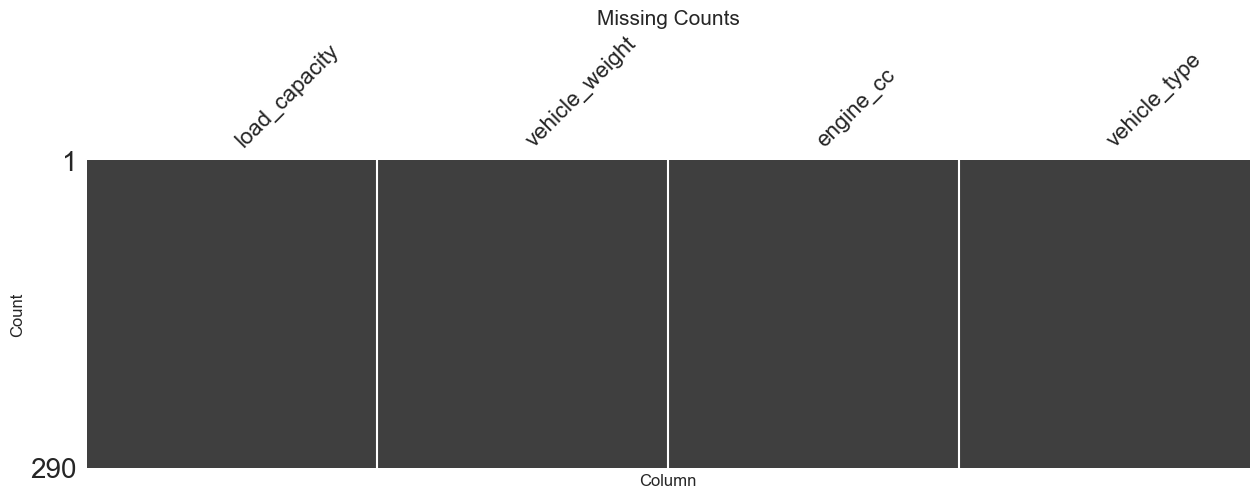

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

missingno.matrix(df_sample_data, ax=axes)
axes.set_title("Missing Counts", size=15)
axes.set_xlabel("Column", size=12)
axes.set_ylabel("Count", size=12)

plt.show()

Observation

- No missing values, hence no need to handle missing values issue

<!--  -->

### EDA

- **`Outliers in Predictors`**

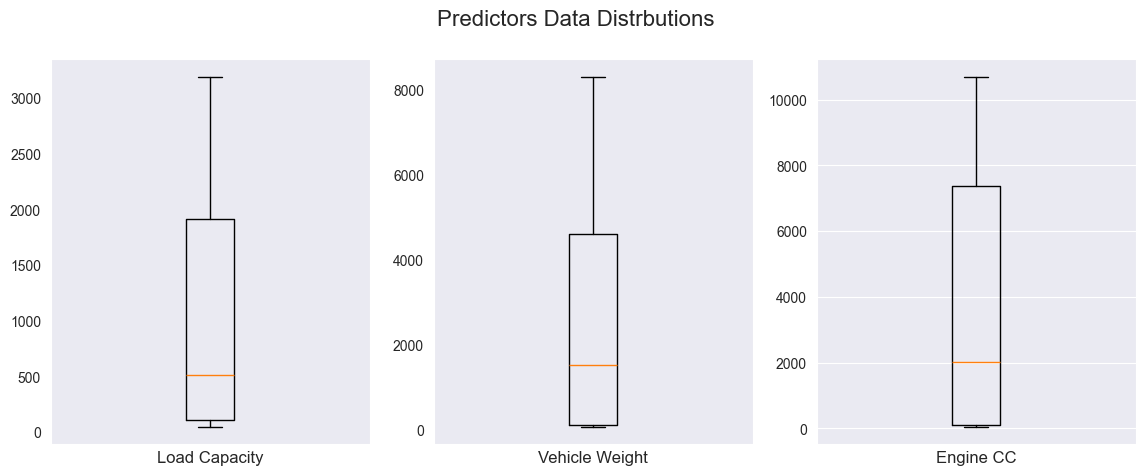

In [49]:
# Plot a box plot
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), sharex=False, sharey=False)
axes[0].boxplot(df_sample_data['load_capacity'])
axes[0].set_xlabel("Load Capacity", fontsize=12)
axes[0].set_xticks([])

axes[1].boxplot(df_sample_data['vehicle_weight'])
axes[1].set_xlabel("Vehicle Weight", fontsize=12)
axes[1].set_xticks([])

axes[2].boxplot(df_sample_data['engine_cc'])
axes[2].set_xlabel("Engine CC", fontsize=12)
axes[2].set_xticks([])

#plt.gca().set_xticks([])
plt.suptitle("Predictors Data Distrbutions", fontsize=16)
plt.grid(True)
plt.show()

Observation

- As there are no potential outliers beyond boxplot whiskers(which is based on IQR rule)
- So outliers handling steps are here not necessary.

- **`Target Variable Distribution`**

In [23]:
df_sample_data.head(2)

,load_capacity,vehicle_weight,engine_cc,vehicle_type
0,134.989095,117.485455,131.960998,bike
1,94.278540,101.433042,134.074436,bike


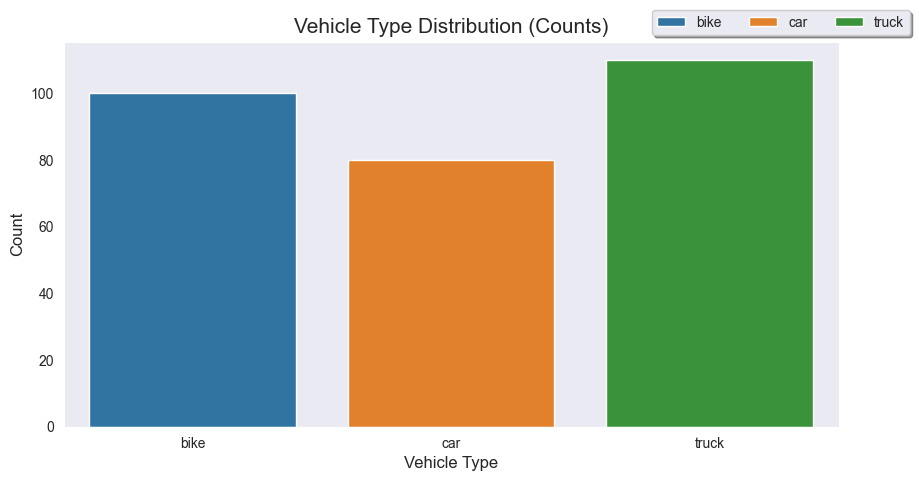

In [27]:
df_counts = df_sample_data.groupby("vehicle_type")["vehicle_type"].value_counts().reset_index()

# Plot
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
# sns.barplot(x="vehicle_type", y="count", data=df_counts, hue="vehicle_type", legend=True, ax=axes)
sns.barplot(x="vehicle_type", y="count", data=df_counts, hue="vehicle_type", legend=True, ax=axes)
axes.set_title("Vehicle Type Distribution (Counts)", size=15)
axes.set_xlabel("Vehicle Type", size=12)
axes.set_ylabel("Count", size=12)
# axes.set_ylim(0, 22)
plt.legend(loc='center left', bbox_to_anchor=(.75, 1.05), fancybox=True, shadow=True, ncol=3, prop={'size':10})
plt.show()

Observation 

- Reasonably balanced dataset, hence we can have good chance of having target variable's all classes in both train and test.
- So need to handle imbalanced dataset steps here.

- **`Predictors vs Target Variable Classes`**

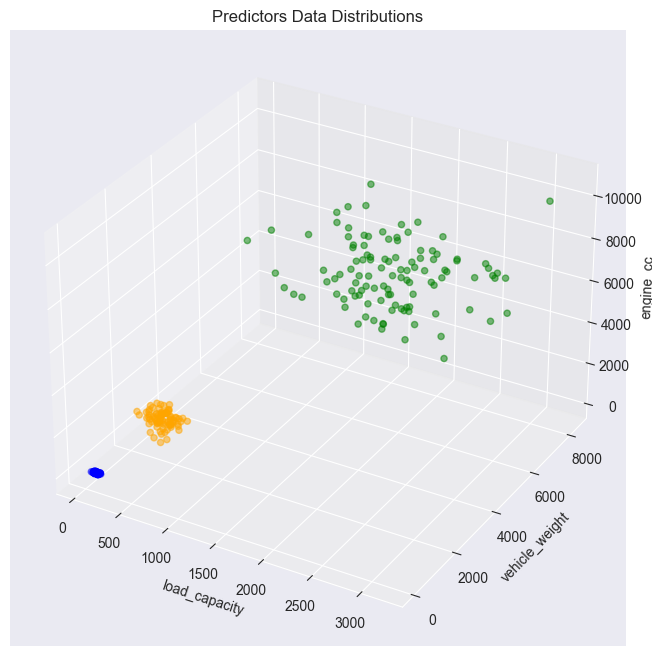

In [94]:
col_1 = "load_capacity"; col_2 = "vehicle_weight"; col_3 = "engine_cc"

sns.set_style("dark")
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
color_map = {'bike': 'blue', 'car': 'orange', 'truck':'green'}
colors = [color_map[x] for x in df_sample_data["vehicle_type"]]
ax.scatter(df_sample_data[col_1],
            df_sample_data[col_2],
            df_sample_data[col_3],
            #c='red',
            c=colors,
            marker='o', 
            alpha=0.5)
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
# plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.title("Predictors Data Distributions")
plt.show()

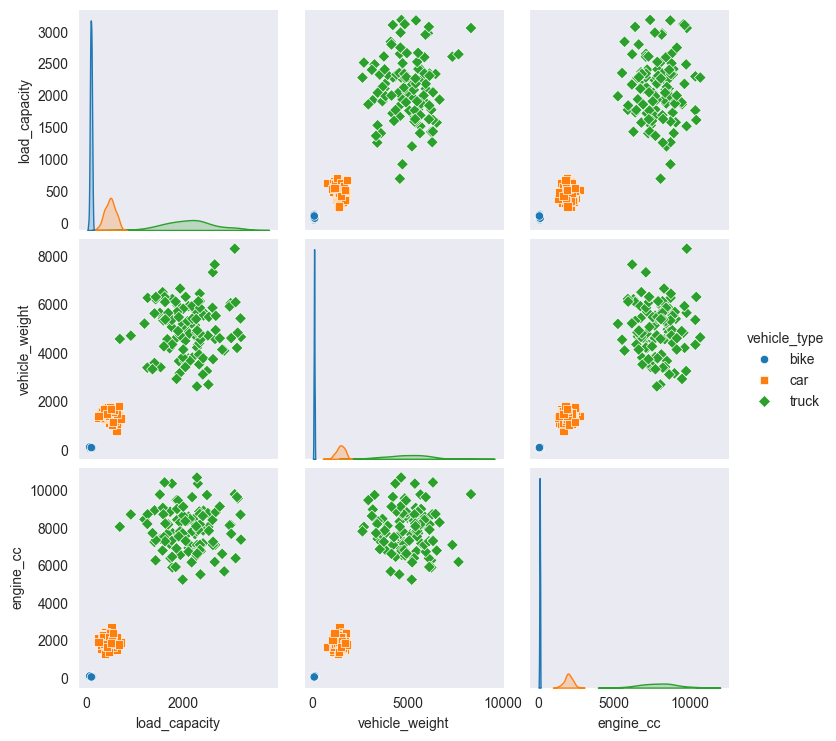

In [52]:
# Pairplot with FacetGrid
sns.set_style("dark")
g = sns.pairplot(df_sample_data, 
                hue='vehicle_type', 
                diag_kind='kde',
                markers=["o", "s", "D"],
                vars=['load_capacity', 'vehicle_weight', 'engine_cc']
                )
# plt.title("Predictors vs Target Variable Labels", fontsize=15)
plt.grid(True)
plt.show()

Observation

- There is a clear separation between all vehicle type's, which helps our model to predict correct target label based on correct neighbours to get the prediction votes.

<!--  -->

### Features Scaling

- KNN is distance-dependent. If features have vastly different scales (e.g., weight(kilos-thousands) vs. engine(cc-hundards)), it can prioritize features with larger scales even if they are less relevant for classification. Scaling features to a similar range can help mitigate this issue.
- Features should be ``normalized`` or ``standardized`` so that they contribute equally to the distance calculation. Without normalization/standardization, features with larger scales can dominate the distance metric.
- As our sample data don't necessarily to be Normally distributed.
- where KNN is non-parametric algorithm, it does not assume any specific data distribution. And it can handle non-linearity in data relation, as predictors don't need to be linear in nature. 

`Normalization`: Min-max scaling, also known as normalization, is a technique to scale features to a fixed range, usually 0 to 1. This is particularly useful in machine learning when the algorithms are sensitive to the scales of the input features, such as k-nearest neighbors and neural networks.

In [54]:
df_sample_data.head(10)

,load_capacity,vehicle_weight,engine_cc,vehicle_type
0,134.989095,117.485455,131.960998,bike
1,94.278540,101.433042,134.074436,bike
2,90.308697,67.218967,68.209602,bike
3,46.933629,87.053947,92.455070,bike
4,99.834307,116.355391,123.250110,bike
5,93.607373,100.735895,72.422826,bike
6,89.267413,99.025949,81.520086,bike
7,106.308053,135.830622,74.049732,bike
8,108.421014,144.037126,72.761315,bike
9,78.687940,99.258662,77.316293,bike


In [60]:
# Initializer
scaler = MinMaxScaler()

# Fit
df_sample_data_scaled = scaler.fit_transform(df_sample_data[["load_capacity", "vehicle_weight", "engine_cc"]])

# Prepare dataframe
df_sample_data_scaled = pd.DataFrame(df_sample_data_scaled, columns=["load_capacity", "vehicle_weight", "engine_cc"])
df_sample_data_scaled["vehicle_type"] = df_sample_data["vehicle_type"]

df_sample_data_scaled.head(10)

,load_capacity,vehicle_weight,engine_cc,vehicle_type
0,0.028017,0.007082,0.007976,bike
1,0.015064,0.005138,0.008174,bike
2,0.013801,0.000993,0.001988,bike
3,0.000000,0.003396,0.004265,bike
4,0.016832,0.006945,0.007158,bike
5,0.014851,0.005053,0.002383,bike
6,0.013470,0.004846,0.003238,bike
7,0.018892,0.009304,0.002536,bike
8,0.019564,0.010298,0.002415,bike
9,0.010104,0.004874,0.002843,bike


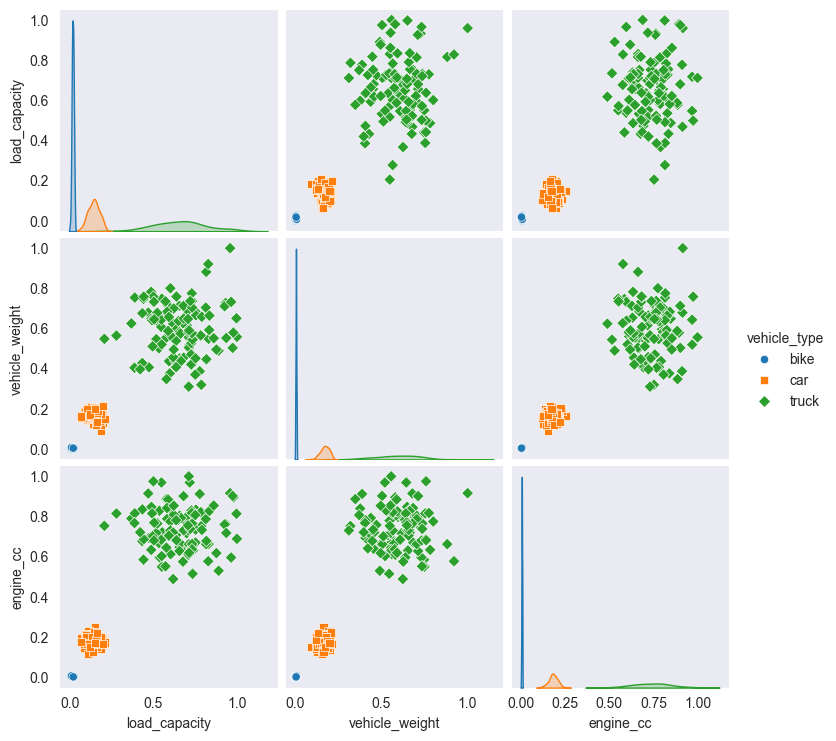

In [61]:
# Pairplot with FacetGrid
sns.set_style("dark")
g = sns.pairplot(df_sample_data_scaled, 
                hue='vehicle_type', 
                diag_kind='kde',
                markers=["o", "s", "D"],
                vars=['load_capacity', 'vehicle_weight', 'engine_cc']
                )
# plt.title("Predictors vs Target Variable Labels", fontsize=15)
plt.grid(True)
plt.show()

Observation

- Internal data distributions still holds after scaling.

<!--  -->

### Predictors Selection

Observation

- All predictors are helping to split data properly. So we are going with all predictors.

<!--  -->

### Local Similarity

- If the intra-class distance is significantly smaller than the inter-class distance, the assumption holds that underlying data whose data points having similar target variable label stays close together, which helps KNN to find right neighbours for prediction new data point.

In [100]:
def get_distances(data, labels):
    
    distances = pairwise_distances(data)
    intra_labels_distances = []
    inter_labels_distances = []

    # Check distances of data points pair's combinations
    for i in range(len(labels)): # Ex:- Starts from 1st label data point, then so on..
        for j in range(i+1, len(labels)): # Ex: Starts from 2nd label data point, then so on..
            if labels[i] == labels[j]:
                intra_labels_distances.append(distances[i][j])
            else:
                inter_labels_distances.append(distances[i][j])
    
    # Compute Avg distances in intra & inter labels distances
    avg_intra_labels_distance = round(np.mean(intra_labels_distances), 2)
    avg_inter_labels_distance = round(np.mean(inter_labels_distances), 2)

    return avg_intra_labels_distance, avg_inter_labels_distance

predictors = df_sample_data_scaled.drop("vehicle_type", axis=1).values # converting to arrays
labels = df_sample_data_scaled["vehicle_type"].values # converting to arrays
intra_avg_distance, inter_avg_distance = get_distances(predictors, labels)

print("Average Intra Labels Distance: {0}".format(intra_avg_distance))
print("Average Inter Labels Distance: {0}".format(inter_avg_distance))

Average Intra Labels Distance: 0.14
Average Inter Labels Distance: 0.82


Observation

- In our underlying data intra-class distance is significantly smaller than the inter-class distance, hence the assumption holds.

<!--  -->

### Train & Test Data Splits

In [62]:
X = df_sample_data_scaled.drop("vehicle_type", axis=1)
y = df_sample_data_scaled["vehicle_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

- Train Data

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232 entries, 164 to 191
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   load_capacity   232 non-null    float64
 1   vehicle_weight  232 non-null    float64
 2   engine_cc       232 non-null    float64
dtypes: float64(3)
memory usage: 7.2 KB


In [64]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 232 entries, 164 to 191
Series name: vehicle_type
Non-Null Count  Dtype 
--------------  ----- 
232 non-null    object
dtypes: object(1)
memory usage: 3.6+ KB


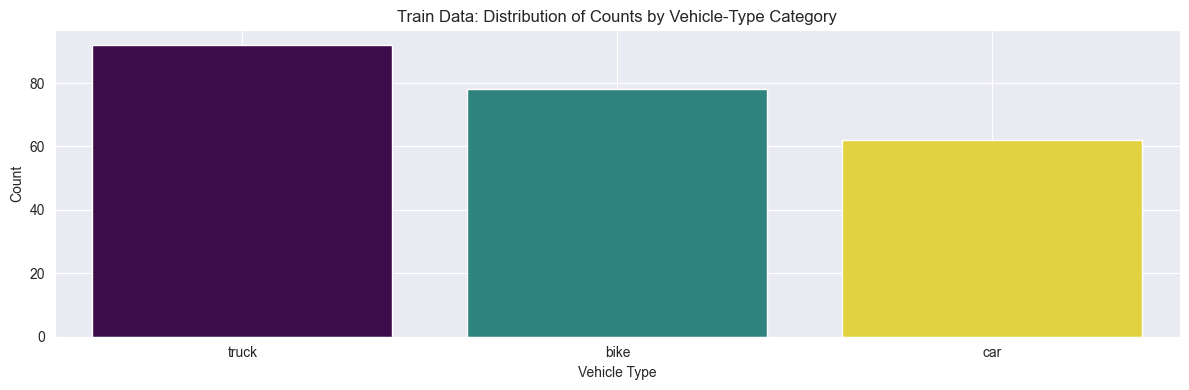

In [67]:
# Class counts
y_train_counts = y_train.value_counts().reset_index()

# Unique classes
categories = y_train_counts.vehicle_type.unique()

# Colors per class
colors = plt.cm.get_cmap('viridis', len(categories)).colors

sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.barplot(x="vehicle_type", y="count", data=y_train_counts, ax=axes, palette=colors)

plt.xlabel("Vehicle Type")
plt.ylabel("Count")
plt.title("Train Data: Distribution of Counts by Vehicle-Type Category")

# plt.legend(categories)
plt.tight_layout()
plt.grid(True)
plt.show()

- Test Data

In [68]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, 183 to 70
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   load_capacity   58 non-null     float64
 1   vehicle_weight  58 non-null     float64
 2   engine_cc       58 non-null     float64
dtypes: float64(3)
memory usage: 1.8 KB


In [69]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 58 entries, 183 to 70
Series name: vehicle_type
Non-Null Count  Dtype 
--------------  ----- 
58 non-null     object
dtypes: object(1)
memory usage: 928.0+ bytes


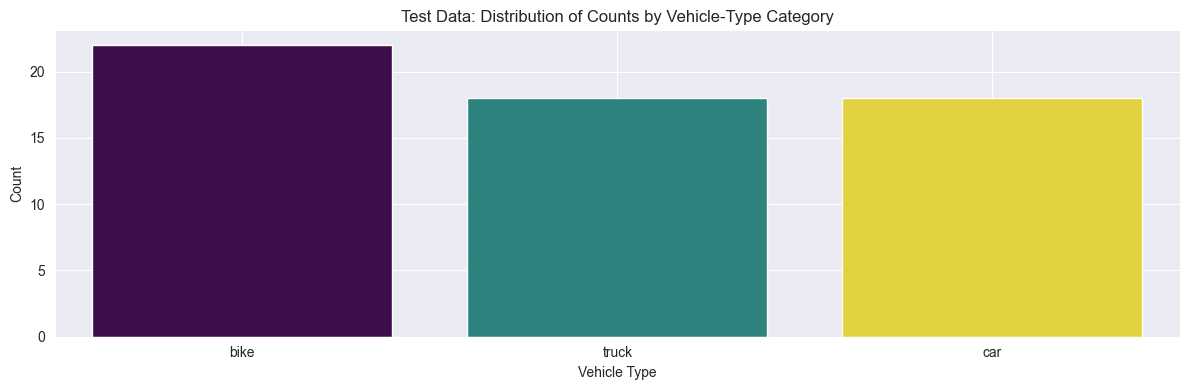

In [71]:
# Class counts
y_test_counts = y_test.value_counts().reset_index()

# Unique classes
categories = y_test_counts.vehicle_type.unique()

# Colors per class
colors = plt.cm.get_cmap('viridis', len(categories)).colors

sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.barplot(x="vehicle_type", y="count", data=y_test_counts, ax=axes, palette=colors)

plt.xlabel("Vehicle Type")
plt.ylabel("Count")
plt.title("Test Data: Distribution of Counts by Vehicle-Type Category")

# plt.legend(categories)
plt.tight_layout()
plt.grid(True)
plt.show()

Observation

- Both classes exists in Train and Test data

- Training Data Predictors Distributions

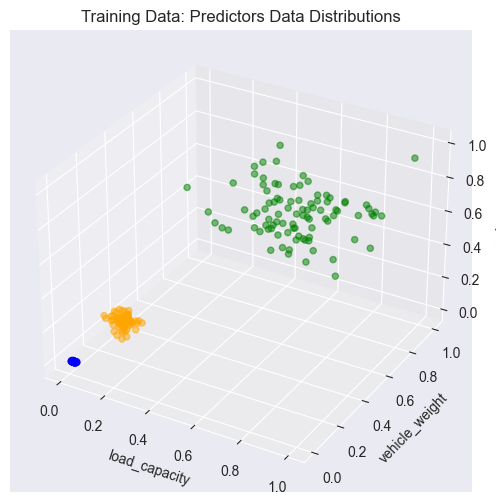

In [97]:
col_1 = "load_capacity"; col_2 = "vehicle_weight"; col_3 = "engine_cc"

sns.set_style("dark")
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111, projection='3d')
color_map = {'bike': 'blue', 'car': 'orange', 'truck':'green'}
colors = [color_map[x] for x in y_train]
ax.scatter(X_train[col_1],
            X_train[col_2],
            X_train[col_3],
            #c='red',
            c=colors,
            marker='o', 
            alpha=0.5)
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
# plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.title("Training Data: Predictors Data Distributions")
plt.show()

Observation

- Training Data has correct data splits without any bias to single target label. Hence model can train well considering all target label patterns and to predict new data point. 

<!--  -->

### KNN Model Training

- It can be sensitive to the choice of the ``distance metric`` and the ``number of neighbors`` (k). 

In [72]:
# Initiate KNN model
knn = KNeighborsClassifier()

# Grid of hyperparameters to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Grid search
grid_search = GridSearchCV(estimator=knn, 
                            param_grid=param_grid, 
                            cv=10, # K-fold cross validation, is general rule of thumb for general Model training  
                            scoring='accuracy',
                            verbose=2,
                            n_jobs=-1 # To use all cpu processesors
                            )

# Hyper parameter tuning
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [74]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)
print("Kfold Cross Validation: Average Accuracy: ", grid_search.best_score_)

Best Hyperparameters:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Kfold Cross Validation: Average Accuracy:  1.0


<!--  -->

### Model Evaluation

> Note: Precision, Recall will be mainly applicable for Binary Classification, not for Multi Class

- Accuracy: Provides an overall measure of correctness, but may not be sufficient if classes are imbalanced. In our case underyling data has mostly balanced classes.

In [119]:
# Predict on the test set using the best found parameters
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print("Test labels: ", y_test[:10].tolist())
print("Predicted labels: ", y_pred[:10], "\n")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:')
# print(classification_report(y_test, y_pred))

# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].


Test labels:  ['truck', 'bike', 'car', 'car', 'bike', 'car', 'car', 'truck', 'truck', 'bike']
Predicted labels:  ['truck' 'bike' 'car' 'car' 'bike' 'car' 'car' 'truck' 'truck' 'bike'] 

Accuracy: 1.00


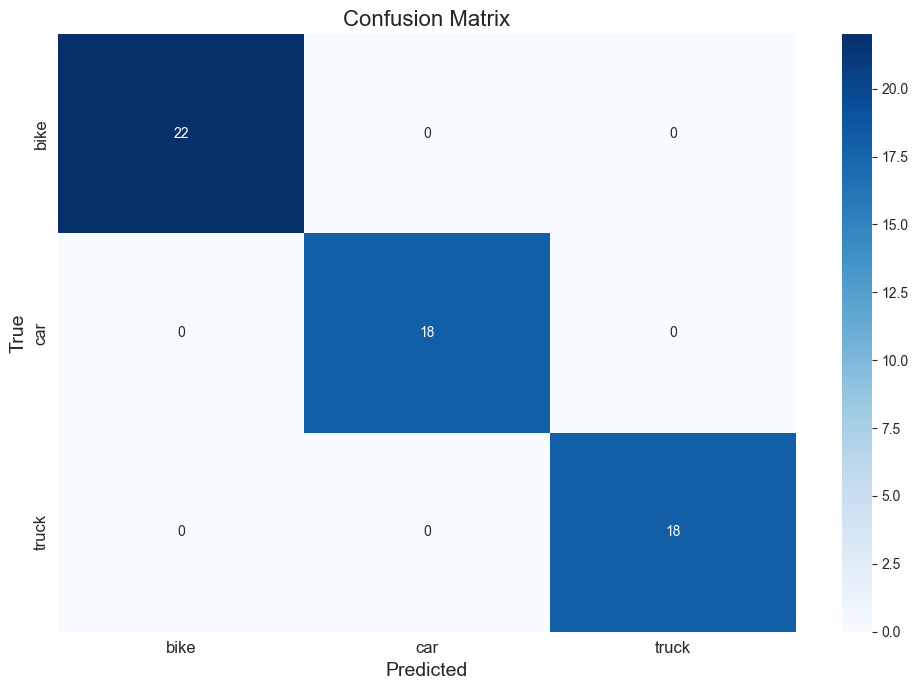

In [111]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

# Plot confusion matrix
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.show()

Observation

- As our sample data in simple, so model trained very well and predicted all labels in test data correctly.

<!--  -->

### Model Interpretation

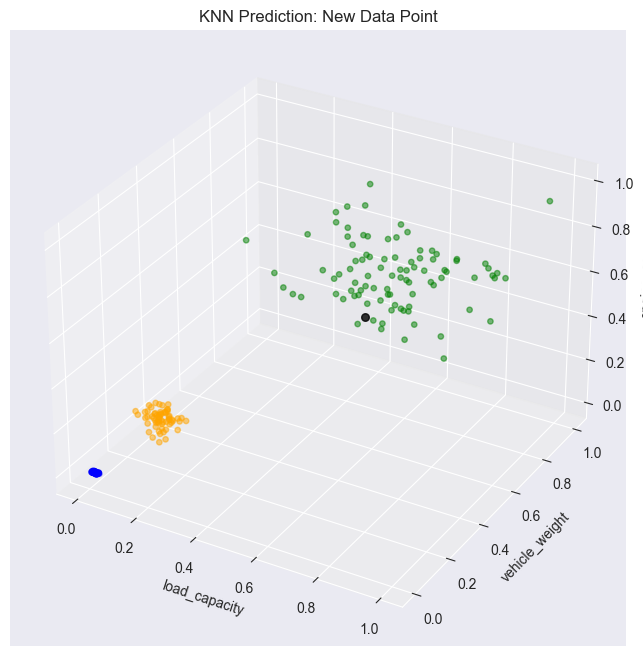

In [134]:
col_1 = "load_capacity"; col_2 = "vehicle_weight"; col_3 = "engine_cc"

sns.set_style("dark")
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
color_map = {'bike': 'blue', 'car': 'orange', 'truck':'green'}
colors = [color_map[x] for x in y_train]
ax.scatter(X_train[col_1], X_train[col_2], X_train[col_3], c=colors, marker='o', s=15, alpha=0.5) # Train Data
ax.scatter(X_test[col_1][:1], X_test[col_2][:1], X_test[col_3][:1], c="black", marker='o', s=30, alpha=0.8) # Test Data
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
# plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.title("KNN Prediction: New Data Point")
plt.show()